# Simulate synthetic AGN signals with K2-motion noise 
## And quantify the effect of detrending on known input

M. Gully-Santiago  
July 1-11, 2019
Kepler/K2 GO Office

In this Jupyter notebook we demonstrate how to simulate AGN signals and bestow its lightcurve with K2 motion-induced instrumental artifacts.  We then "round-trip" the artificial signals through detrending algorithms to quantify the extent to which the desired science signal gets degraded.  

This demo employs these non-standard or Kepler-specific packages:
- [scope](https://github.com/nksaunders/scope) for simulating K2 motion noise
- [lightkurve](https://github.com/keplerGO/lightkurve) for retrieving and inspecting the genuine AGN TPF, and for the detrending algorithms
- [celerite](https://github.com/dfm/celerite) for simulating the correlated lightcurve arising from an AGN with a damped random walk.

We'll first have to install the development version of `scope` along with some standard supporting code (i.e. software dependencies like scipy, etc.).  I recommend conda to install these.

In [1]:
import numpy as np
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.timeseries import LombScargle

In [2]:
import scope
import lightkurve as lk
import everest

In [3]:
from nfft import nfft

Let's turn off `DEBUG` logging messages.

In [4]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

# Simulate an Active Galactic Nucleus Lightcurve


<img width=250 src=https://iopscience.iop.org/0004-637X/857/2/141/downloadFigure/figure/apjaab88df7 ></src>

From K. Smith et al. 2018, Section 5:
> The variability of AGN is a red noise process, meaning that successive samples are correlated in time. The power spectra of such processes are well described by a power law, where the spectral density S varies with the temporal frequency as:

$$ S \propto f^\alpha$$


K. Smith et al. find this histogram:

<img width=250 src=https://iopscience.iop.org/0004-637X/857/2/141/downloadFigure/figure/apjaab88df9></img>


First let's get genuine data to mimic the in-situ K2 motion properties as close as we can for a genuine source.

In [5]:
genuine_tpf = lk.search_targetpixelfile('EPIC 220182448', mission='K2', campaign=8).download()

You can use `genuine_tpf.interact()` to generate a *custom* aperture mask, **or** take the exact same mask as Everest.  Let's do the latter.  You can use `lc_Everest.dvs()` to see a data validation summary of the Everest data.

In [6]:
lc_Everest = everest.Everest(220182448, season=8, mission='k2')

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220182448.


In [7]:
aperture_mask = lc_Everest.aperture.astype(np.bool)

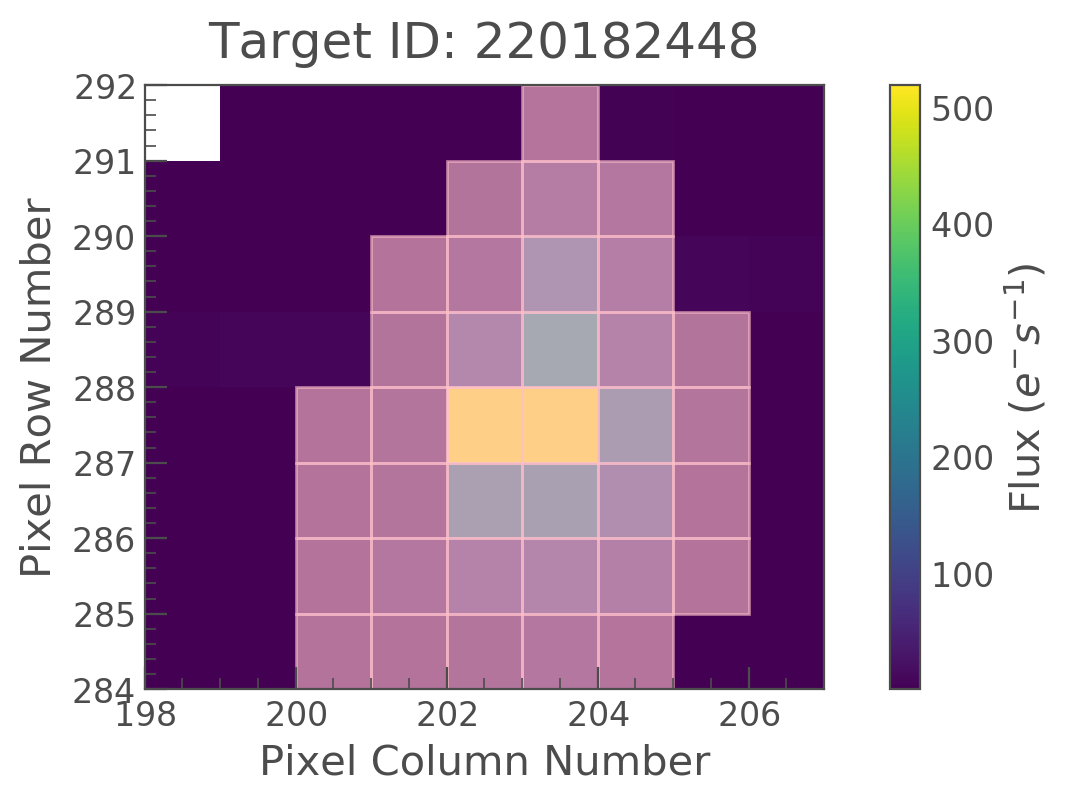

In [8]:
genuine_tpf.plot(aperture_mask=aperture_mask);

In [9]:
lc = genuine_tpf.to_lightcurve(aperture_mask=aperture_mask)
n_cad, = lc.time.shape
n_cad

3595

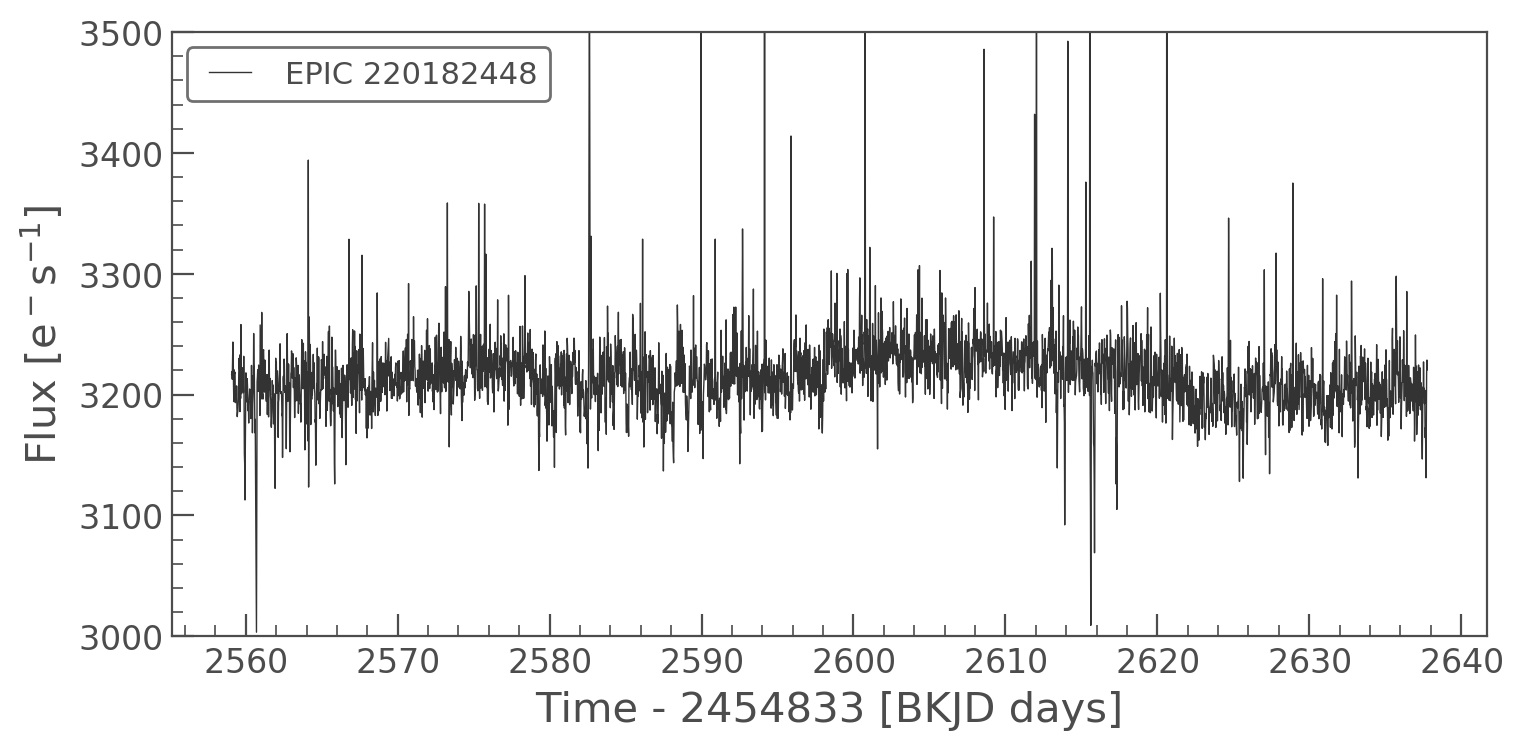

In [10]:
lc.plot(normalize=False)
plt.ylim(3000, 3500);

The lightcurve has some large jumps, likely spurious spacecraft-motion-induced outliers.  The mean level drifts in time, which may stem from bona-fide AGN variability or spacecraft thermal cycles or secular motion artifacts.

# Modeling a damped random walk.

The Power Spectral Density (PSD) for a damped random walk resembles this form [(Uhlenbeck & Ornstein 1930)](http://adsabs.harvard.edu/abs/1930PhRv...36..823U):

$$S(\omega) = \sqrt{\frac{2}{\pi}}\,\frac{a}{c}\,
    \frac{1}{1+{\left(\frac{\omega}{c}\right)}^2} \quad$$
    
    
where we use $\omega = 2 \pi f$, the angular frequency.  This PSD has the Gaussian Process [(Foreman-Mackey et al. 2017)](https://ui.adsabs.harvard.edu/abs/2017AJ....154..220F/abstract) **kernel** $k$: 
$$k(\tau_{nm}) = a\,e^{\left(-c\,\tau_{nm}\right)}$$  

Note that in the limit of large frequencies ($f\rightarrow \infty$), the PSD is approximated as a power law with $\alpha=-2$:

$$\lim_{\omega \gg c} S(\omega) \rightarrow \sqrt{\frac{2}{\pi}}\,\frac{a}{c}\,
    \left(\frac{\omega}{c}\right)^{-2} \quad$$
    
We can set $c$ through a desire to have a powerlaw slope through the entire observation window:

$$c \gtrsim2 \pi \frac{1}{T_{K2}}$$

Let's set the characteristic time scale as 0.1 years.


In [17]:
t_char = (0.1*u.year).to(u.second)
c_val = 2.0*np.pi * 1/(t_char)
c_val.to(u.Hz) # units of Hz

<Quantity 1.99102128e-06 Hz>

What about the value of $a$?  It should have units of $(\mathrm{dimensionless\; power}\cdot \mathrm{Hz})$, so it should be comparable to $c$ to achieve near-unity power.

In [18]:
a_val = c_val*3e7
a_val.to(u.Hz)

<Quantity 59.73063833 Hz>

## Simulate the noise-free PSD with `celerite`

We follow the PSD normalization example from the [celerite documentation](https://celerite.readthedocs.io/en/stable/tutorials/normalization/).

In [19]:
from astropy.timeseries import LombScargle
import celerite
from celerite import terms

Note that celerité follows the numpy convention of **natural logs** $\ln{}$ for all $\log{}$ functions, unless explicitly providing base 10.

>Args:  
    - log_a (float): The log of the amplitude of the term.  
    - log_c (float): The log of the exponent of the term.

In [20]:
true_logc, true_loga = np.log(c_val.value) , np.log(a_val.value)

In [21]:
kernel = terms.RealTerm(log_a=true_loga, log_c=true_logc) 

In [22]:
gp = celerite.GP(kernel, mean=3200, fit_mean=True)

In [23]:
# Simulate K datasets with N points
t = (lc.time*u.day).to(u.second).value

In [24]:
gp.compute(t)

In [25]:
np.random.seed(42)
NN = n_cad
KK = 500
y = gp.sample(size=KK)

y.shape

(500, 3595)

We *do not* have evenly spaced frequencies, so we technidally shouldn't use the numpy implementation of FFT from the celerite example.  Instead we should use the `NFFT` algorithm:
https://github.com/jakevdp/nfft  
This algorithm requires some extra preprocessing and tuning, so I will leave that as an exercise for the future.

In [26]:
# Compute the FFT based power spectrum estimates
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fft = np.array(list(map(np.fft.rfft, y)))
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
power_fft = fft.real / NN**2

In [28]:
# Compute the LS based power spectrum estimates
power_ls = []
for y0 in y:
    model = LombScargle(t, y0)
    power_ls.append(model.power(f[1:-1], method="slow", normalization="psd"))
power_ls = np.array(power_ls)

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_ls /= NN

In [29]:
# Compute the true power spectrum
# NOTE: the 2*pi enters because celerite computes the PSD in _angular_ frequency
power_true = kernel.get_psd(2*np.pi*f)

# >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
power_true /= 2*np.pi

In [30]:
#  EQN 13 of DFM et al. celerite paper
analytic_power = np.sqrt(2/np.pi)*np.exp(true_loga)/np.exp(true_logc)*1/(1+(2.0*np.pi*f/np.exp(true_logc))**2) / (2*np.pi)

In [31]:
fake_omega = np.logspace(-6, -4, base=10)
fake_pow = fake_omega**(-2) / 1e9

/Users/obsidian/anaconda3/envs/scope_dev/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


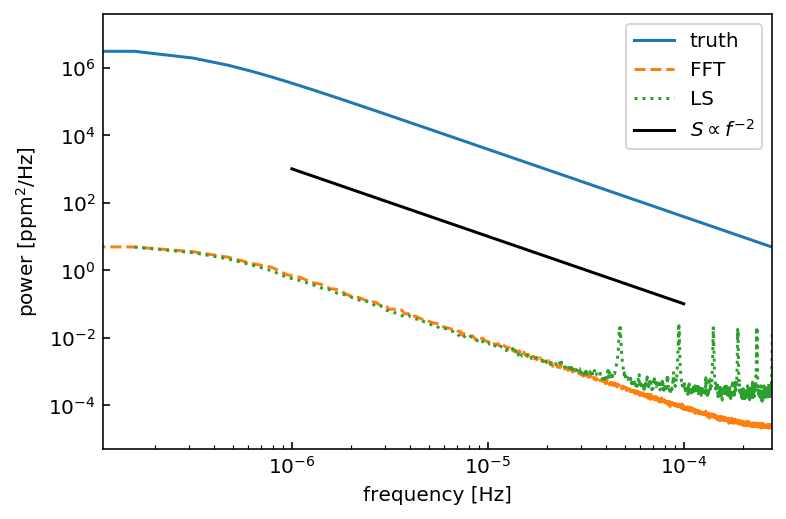

In [32]:
# Let's plot the estimates of the PSD
plt.figure()
#plt.plot(f, power_true, label="truth")
plt.plot(f, power_true, label="truth")
#plt.plot(f, analytic_power, label='analytic')
plt.plot(f, np.median(power_fft, axis=0), "--", label="FFT")
plt.plot(f[1:-1], np.median(power_ls, axis=0), ":", label="LS")
plt.yscale("log")
plt.xscale("log")
plt.xlim(f.min(), f.max())
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")

plt.plot(fake_omega, fake_pow, 'k-', label='$S \propto f^{-2}$')

plt.legend()

The normalization scale diverges for [unknown reasons](https://github.com/dfm/celerite/issues/140) but the shape is always preserved.

In [33]:
simulated_signal = y[9, :]

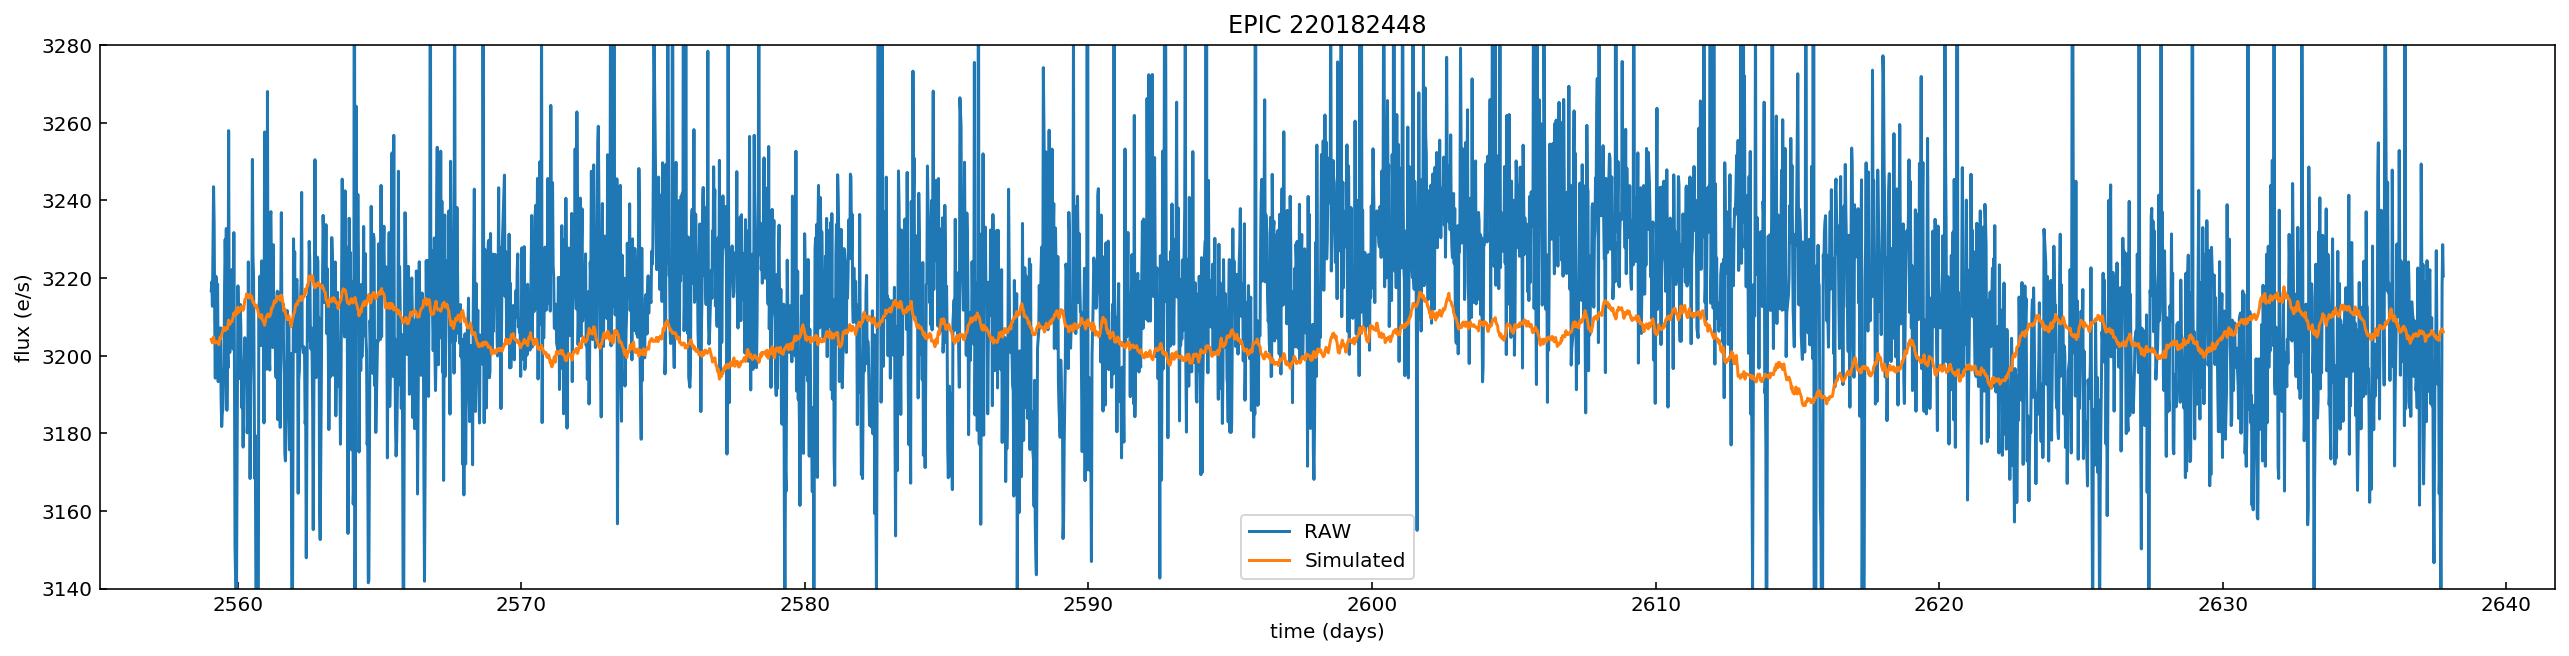

In [34]:
plt.figure(figsize=(22, 5))
plt.plot(lc.time, lc.flux, label='RAW')
plt.plot(t/60/60/24 , simulated_signal, label='Simulated')
plt.ylim(3140, 3280)
plt.title('EPIC {}'.format(lc.targetid))
plt.xlabel('time (days)')
plt.ylabel('flux (e/s)')
plt.legend();

A signal with the simulated amplitude could plausibly reside in the data, at just below the signal-to-noise ratio to detect by eye.

# Make a scope-produced lightkurve

Text(0.5, 1.0, 'K2 motion exceeds one pixel')

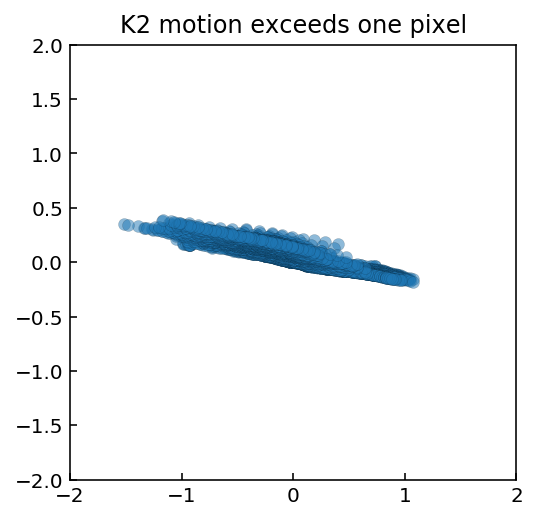

In [35]:
plt.figure(figsize=(4,4))
plt.scatter(genuine_tpf.pos_corr1, genuine_tpf.pos_corr2, alpha=0.5, ec='k', lw=0.1)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title('K2 motion exceeds one pixel')

In [36]:
scope_logger = logging.getLogger('scope') 
scope_logger.setLevel(logging.WARNING) 

In [37]:
targ_mag = genuine_tpf.hdu[0].header['KEPMAG']

### Run `scope`
Running scope can take 10+ minutes to generate the 3500+ cadence target, and another 10 minutes to add variability to the target.

In [38]:
overwrite_FITS_simulation = False

In [39]:
if overwrite_FITS_simulation:
    
    # Run scope for all n_cad cadences-- this procedure takes a long time, ~ 20+ minutes.
    target = scope.generate_target(mag=targ_mag, ID=lc.targetid, ncadences=n_cad)
    target_AGN = copy.copy(target)
    # The custom variability expects a *multiplicative* signal, so its mean should be 1.0.
    target_AGN.add_variability(custom_variability=simulated_signal/np.mean(simulated_signal))

    # Make a synthetic Target Pixel File (TPF) with additional metadata
    AGN_tpf = target_AGN.to_lightkurve_tpf(target_id="simulated_AGN_celerite_RW")
    
    # Add a column and row keyword mimicking the Genuine TPF
    col = genuine_tpf.get_keyword('1CRV5P', hdu=1, default=0)
    row = genuine_tpf.get_keyword('2CRV5P', hdu=1, default=0)
    AGN_tpf.hdu[1].header.set('1CRV5P', value=col)
    AGN_tpf.hdu[1].header.set('2CRV5P', value=row)

    # Add the noiseless input as an additional fits HDU entry
    extra_hdu = fits.BinTableHDU.from_columns([fits.Column(name='NOISELESS_INPUT', format='E', 
                                     array=simulated_signal/np.mean(simulated_signal))])
    extra_hdu.name = 'SIMULATED_SIGNAL'
    AGN_tpf.hdu.append(extra_hdu)
    
    # List the "True" parameter values that generated the noiseless input
    AGN_tpf.hdu[3].header.set('log_a', value=true_loga, comment='ln of celerite a value')
    AGN_tpf.hdu[3].header.set('log_c', value=true_logc, comment='ln of celerite c value ')
    AGN_tpf.hdu[3].header.set('celmean', value=3200, comment='Mean of pre-normed celerite GP')

    # Save and overwrite the fits files
    AGN_tpf.to_fits(output_fn='synthetic-k2-AGN.targ.fits', overwrite=True)

In [40]:
if not overwrite_FITS_simulation:
    
    # Read in the existing fits file
    AGN_tpf = lk.KeplerTargetPixelFile('synthetic-k2-AGN.targ.fits')

0% (0/3595) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


INFO  [lightkurve.utils.create_quality_mask()]: 0% (0/3595) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


### Apply the SFF *and* PLD algorithms to the simulated signals to evaluate their performance

#### "Self Flat Fielding" [(SFF, Vanderburg et al. 2015)](http://adsabs.harvard.edu/abs/2014PASP..126..948V)

In [41]:
ap_mask = AGN_tpf.create_threshold_mask()

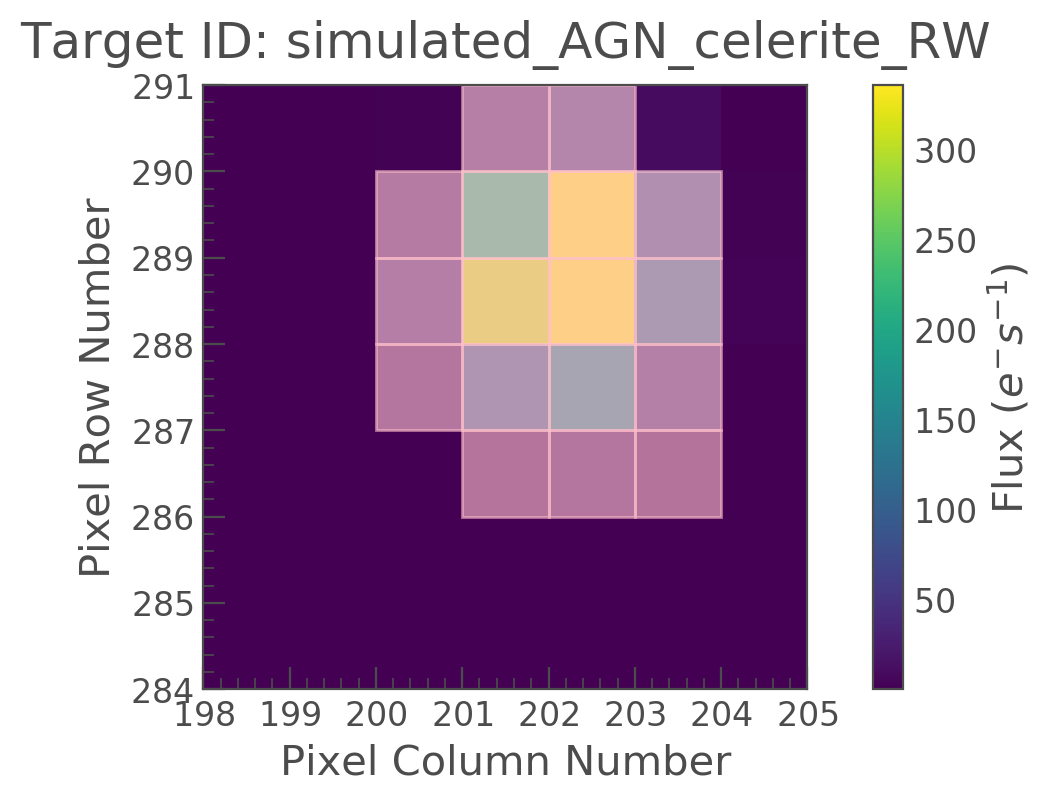

In [42]:
AGN_tpf.plot(aperture_mask=ap_mask);

In [43]:
custom_lc = AGN_tpf.to_lightcurve(aperture_mask=ap_mask)

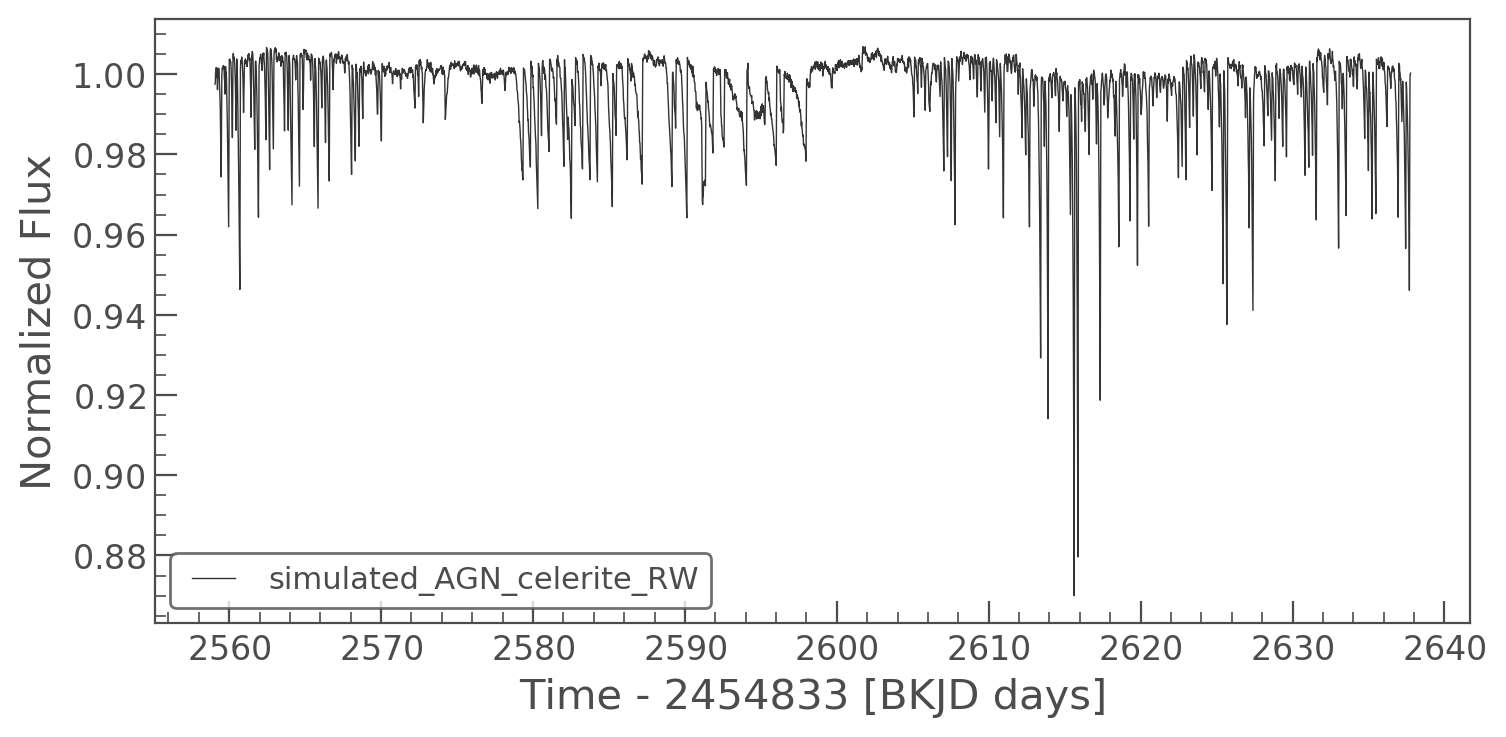

In [44]:
custom_lc.plot();

Looks lousy!  The K2 motion noise is much greater than the AGN signal.

In [45]:
corrector = lk.SFFCorrector(custom_lc)
cor_lc = corrector.correct(AGN_tpf.pos_corr2, AGN_tpf.pos_corr1, 
                             niters=4, windows=5, bins=7, restore_trend=True)

#### Pixel Level Deconvolution [(PLD Luger et al. 2016)](http://adsabs.harvard.edu/abs/2016AJ....152..100L)

In [46]:
corrector = lk.PLDCorrector(AGN_tpf)
cor_lc2 = corrector.correct(use_gp=True, aperture_mask=ap_mask, pld_aperture_mask=ap_mask)

#### True signal

In [47]:
true_signal = AGN_tpf.hdu['SIMULATED_SIGNAL'].data['NOISELESS_INPUT']

How do the detrended signals resemble the noiseless input?

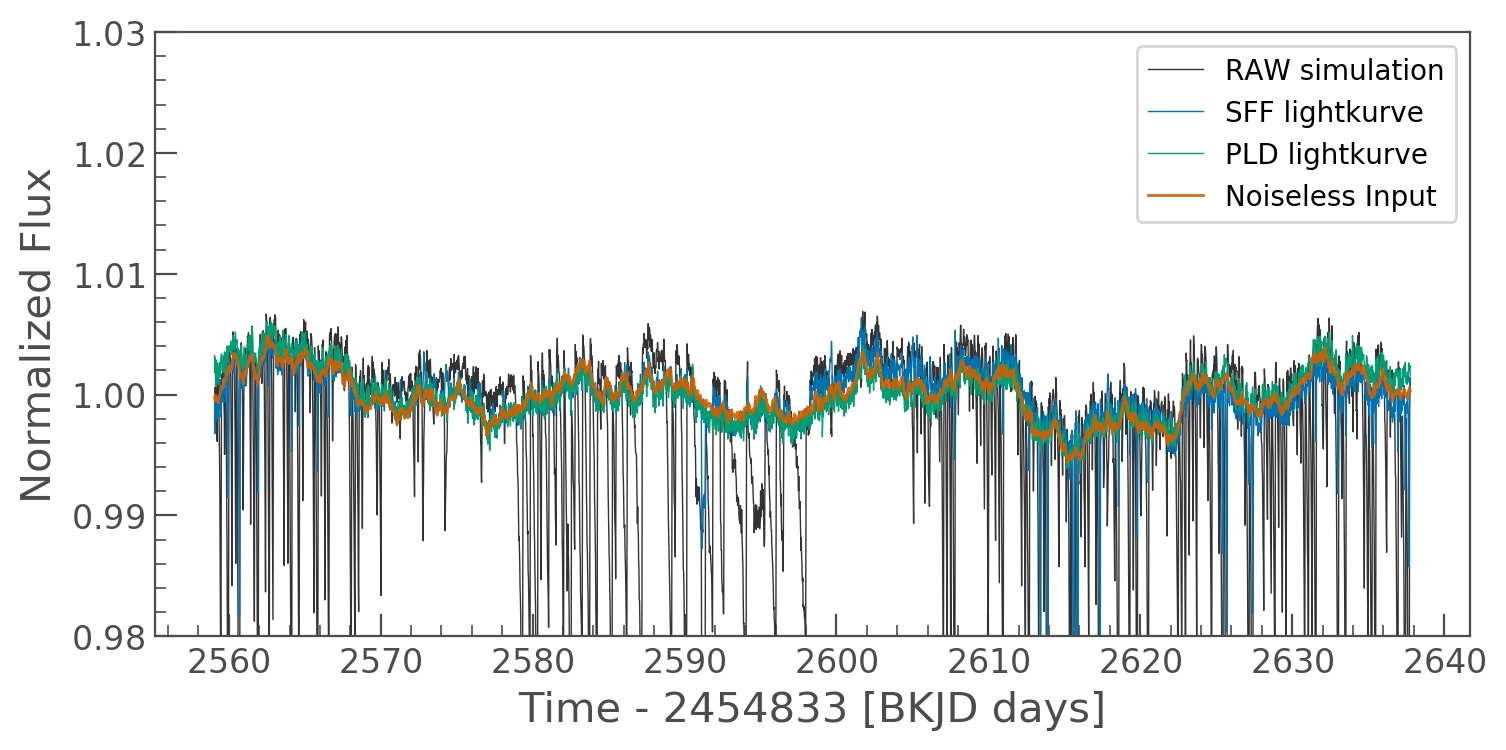

In [48]:
ax = custom_lc.plot(label='RAW simulation')
cor_lc.plot(label='SFF lightkurve', ax=ax)
cor_lc2.plot(label='PLD lightkurve', ax=ax)
plt.plot(AGN_tpf.time, true_signal, label='Noiseless Input', alpha=0.9, lw=1)
plt.legend(loc='best')
plt.ylim(0.98, 1.03)
plt.savefig('AGN_K2_demo_scope_lightcurve.png', dpi=300, bbox_inches='tight')

Nice!  The detrending algorithms track the noiseless input pretty closely, but not *perfectly*.  How do these imperfections in the reconstructed lightcurve alter the **Power Spectral Density**?  
Our next step is to compute their PSDs to see.

In [49]:
t = ((AGN_tpf.time-AGN_tpf.time[0])*u.day).to(u.second).value

In [50]:
# Compute the FFT based power spectrum estimates
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fft = np.fft.rfft(custom_lc.flux)
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
power_fft2 = fft.real / NN**2

In [51]:
# Compute the FFT based power spectrum estimates
fft = np.array(list(np.fft.rfft(cor_lc.flux)))
fft *= np.conj(fft)

power_fft3 = fft.real / NN**2

In [52]:
# Compute the FFT based power spectrum estimates
fft = np.array(list(np.fft.rfft(cor_lc2.flux)))
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
power_fft4 = fft.real / NN**2

In [53]:
# Compute the FFT based power spectrum estimates
fft = np.array(list(np.fft.rfft(true_signal*3200.0)))
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
power_fft5 = fft.real / NN**2

In [54]:
import seaborn as sns

In [55]:
sns.set_context('talk')

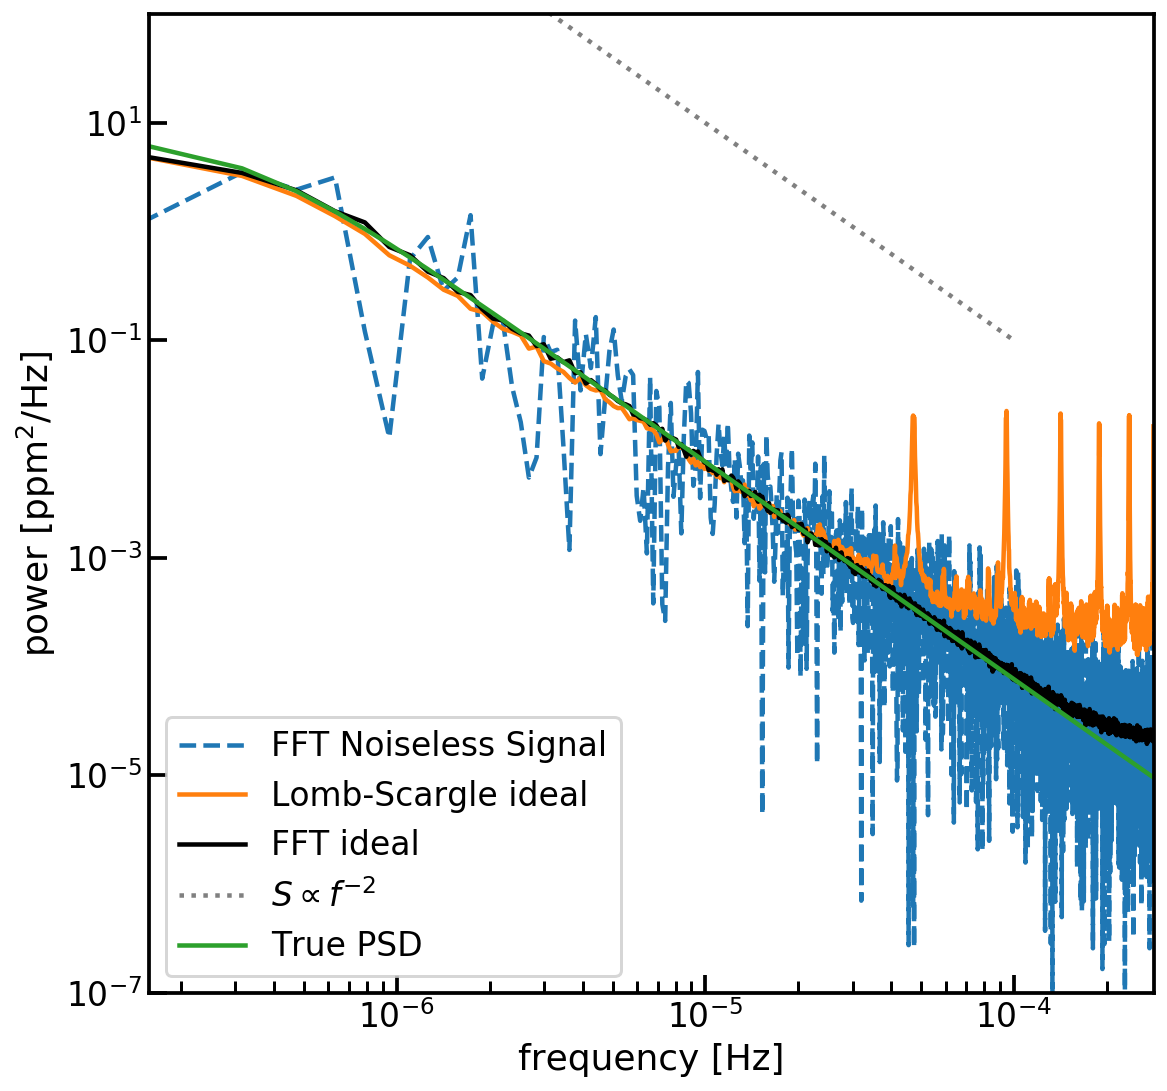

In [57]:
# Let's plot the estimates of the PSD
plt.figure(figsize=(9, 9))
plt.plot(f, power_fft5, "--", label="FFT Noiseless Signal")
plt.plot(f[1:-1], np.median(power_ls, axis=0), "-", label="Lomb-Scargle ideal")
plt.plot(f, np.median(power_fft, axis=0), "k-", label="FFT ideal")
plt.yscale("log")
plt.xscale("log")
plt.xlim(f[1:].min(), f.max())
plt.ylim(1e-7, 1e2)
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")
plt.plot(fake_omega, fake_pow, ':', color='gray', label='$S \propto f^{-2}$')
plt.plot(f, power_true/5e5, label="True PSD")

plt.legend()

plt.savefig('AGN_K2_PSD_demo.png', dpi=300, bbox_inches='tight')

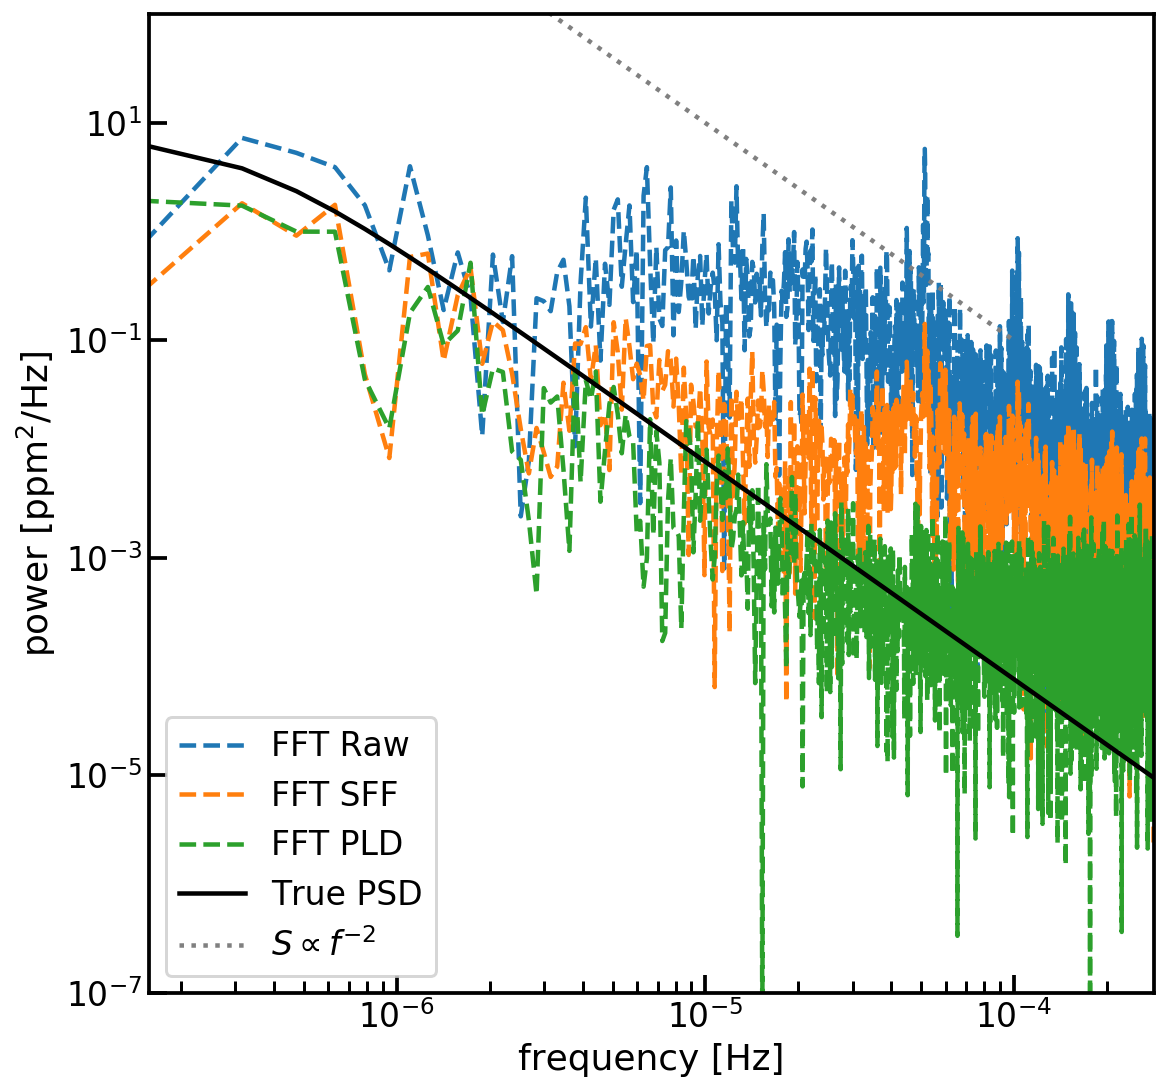

In [60]:
# Let's plot the estimates of the PSD
plt.figure(figsize=(9, 9))
#plt.plot(f, analytic_power, label='analytic')
plt.plot(f, power_fft2, "--", label="FFT Raw")
plt.plot(f, power_fft3, "--", label="FFT SFF")
plt.plot(f, power_fft4, "--", label="FFT PLD")
#plt.plot(f[1:-1], np.median(power_ls, axis=0), "-", label="LS ideal")
plt.plot(f, power_true/5e5, 'k', label="True PSD")
plt.yscale("log")
plt.xscale("log")
plt.xlim(f[1:].min(), f.max())
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")

plt.plot(fake_omega, fake_pow, ':', color='gray', label='$S \propto f^{-2}$')
plt.ylim(1e-7, 1e2)
plt.legend()

plt.savefig('AGN_K2_PSD_demo_detrend.png', dpi=300, bbox_inches='tight')

### Key insights  

1. Detrending successfully mitigate some instrumental noise, but is---necessarily---imperfect.
2. Imperfections in detrending algorithms lead to additional structures in PSD that bias the derived PSD slope.
3. The choice of detrending algorithm matters; here, PLD seems to out-perform SFF in the fidelity of the PSD slope.  This performance advantage may not be universal.
4. We did not show how the choice of tuning parameters may improve or degrade the retrieved PSD slope, but we suspect that investigations into such tuning could be merited.
5. Gaussian process regression may be an effective technique for PSD slope modeling.  Fast implementations such as celerite could provide direct inference of correlation scale lengths---and their uncertainties---that govern the PSD slopes.
6. Celerite, scope, and lightkurve offer convenience functions for simulating signals in K2 lightkurves.